In [238]:
import networkx as nx
import seaborn as sns
from pathlib import Path
import torch
import DQN_agent_modular
from envs.GraphEnv.impnode import ImpnodeEnv
from DQN.train_dqn import finetune_dqn2, fill_memory2, finetune_trial
from test_and_compare import test_loop, hda
import matplotlib.pyplot as plt
import  numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [239]:
import random

seed = 412
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [240]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RESULTS_BASEPATH_TEST1 = 'results/hyp_search/cuda_0.001_3000_500_0.99_64_1500_100_1.0_0.05_100_0.001_4_2_32_64_1_3_(30, 50)_4_dw_nd_4_None'


In [241]:
# variables for training the agent

num_train_eps = 1000 #10000 number training episodes to run
num_mem_fill_eps = 1000 #1000 number of episodes to run to initialize the memory
discount = 0.99 # gamma used for computing return
batch_size = 64 # number of transitions to sample from replay buffer for each learn step
mem_capacity = 5000 # 500000 size of the memory buffer
update_frequency = 100 #1000 number of interactions after which the target buffer is updated
eps_max = 1 # initial epsilon value
eps_min = 0.05 # final epsilon value
eps_step = 200 #1000 amount by which epsilon is decayed at each episode
lr = 0.0002 # learning rate for the network
alpha = 0.001
gnn_depth=4
state_size=2
hidden_size1=32
hidden_size2=64
action_size=1
n_step=3

ba_nodes = (30, 50)
ba_edges=4
anc = 'dw_nd'
max_removed_nodes = 4
seed = None


In [242]:
# create the dqn_agent
dqn_agent_train = DQN_agent_modular.DQNAgent(device,
                                             alpha=alpha,
                                             gnn_depth=gnn_depth,
                                             state_size=state_size,
                                             hidden_size1=hidden_size1,
                                             hidden_size2=hidden_size2,
                                             action_size=action_size,
                                             discount=discount,
                                             eps_max=eps_max,
                                             eps_min=eps_min,
                                             eps_step=eps_step,
                                             memory_capacity=mem_capacity,
                                             lr=lr,
                                             mode='finetune')
dqn_agent_train.load_model('{}/model.pt'.format(RESULTS_BASEPATH_TEST1))
#dqn_agent_train.save_model('{}_finetune/model.pt'.format(RESULTS_BASEPATH_TEST1))

linear1 is frozen
linear2 is frozen
linear3 is frozen
linear4 is unfrozen
sum_agg is frozen
linear5 is unfrozen
dense1 is unfrozen
dense2 is unfrozen


In [243]:
subdir = 'data/cm/Crime'
data_path = Path.cwd() / subdir
finetuned_base_path = 'crime_4_5_6_7_finetuned_model'
env_train = ImpnodeEnv(anc=anc,
                       ba_nodes=ba_nodes,
                       ba_edges=ba_edges,
                       seed=seed,
                       render_option=False,
                       mode='finetune',
                       max_removed_nodes=max_removed_nodes,
                       data_path=data_path)
fill_memory2(env_train, dqn_agent_train, num_mem_fill_eps, n_step)

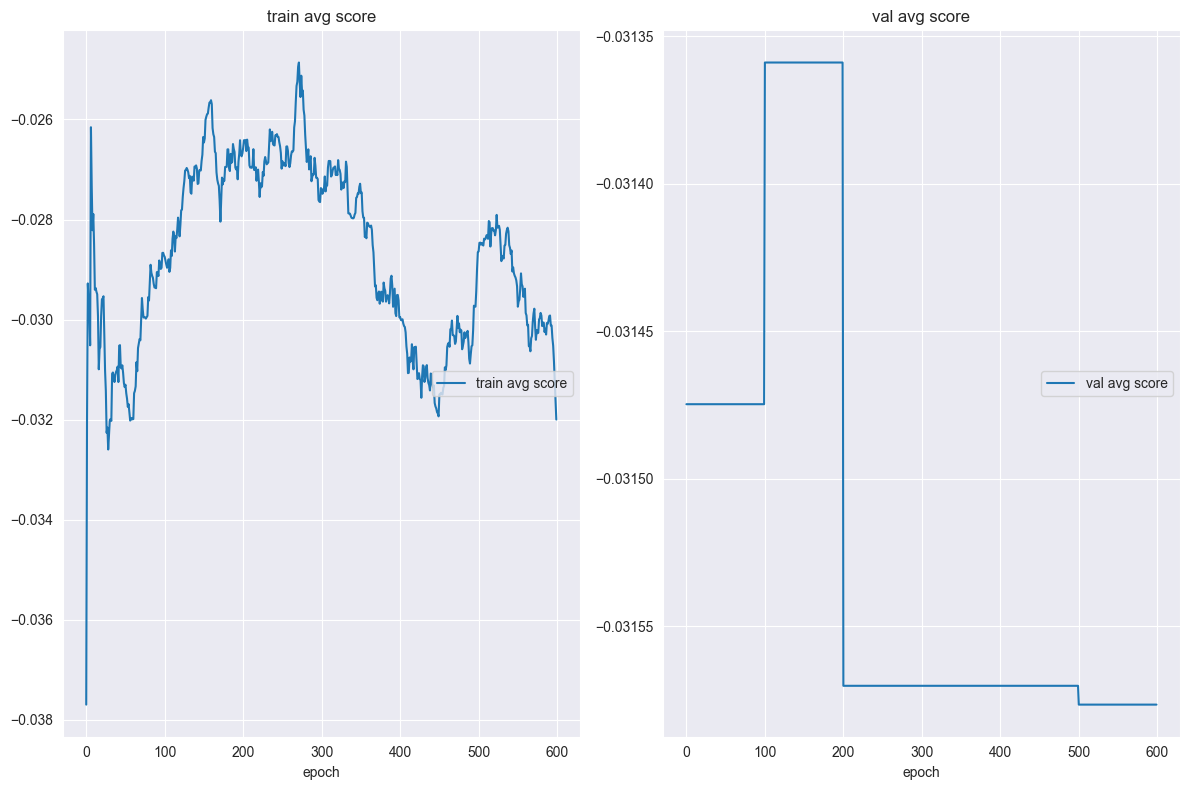

train avg score
	train avg score  	 (min:   -0.038, max:   -0.025, cur:   -0.032)
val avg score
	val avg score    	 (min:   -0.032, max:   -0.031, cur:   -0.032)
EarlyStopping counter: 5 out of 5
Early stopping
Finished


In [244]:
finetune_trial(env_train, dqn_agent_train, RESULTS_BASEPATH_TEST1,num_train_eps, n_step, batch_size, update_frequency, finetuned_base_path)

print('Finished')

subdir = 'data/cm/Crime'
data_path = Path.cwd()/subdir

env_train = ImpnodeEnv(anc=anc, 
                       ba_nodes=ba_nodes, 
                       ba_edges=ba_edges,  
                       seed=seed, 
                       render_option=False, 
                       mode='finetune',
                       max_removed_nodes=max_removed_nodes,
                       data_path=data_path)
fill_memory2(env_train, dqn_agent_train, num_mem_fill_eps, n_step)
finetune_dqn2(dqn_agent_train, num_train_eps, RESULTS_BASEPATH_TEST1, batch_size)
print('Finished')